## Explore TF isoform expression data

TODO
- try taking just 2 or 3 samples in the same data point
- compare adult tissues in GTEx and development
- can we do some statistics???

In [215]:
import os
from itertools import combinations

import numpy as np
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


# import ccsblib
# from ccsblib import ccsbplotlib as cplt

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_annotated_gencode_tfs,
                          load_y1h_pdi_data,
                          load_m1h_activation_data,
                          load_valid_isoform_clones,
                          load_seq_comparison_data,
                          load_gtex_gencode,
                          load_developmental_tissue_expression_gencode)

In [216]:
tfs = load_annotated_gencode_tfs()

df_gtex, metadata_gtex, genes_gtex = load_gtex_gencode()

#TODO: move to data_loading
exclusion_list_gtex = {'Cells - Leukemia cell line (CML)',
                       'Cells - EBV-transformed lymphocytes',
                       'Cells - Cultured fibroblasts'}
df_gtex = df_gtex.loc[:, ~df_gtex.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex = metadata_gtex.loc[~metadata_gtex['body_site'].isin(exclusion_list_gtex), :]

means_gtex = df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean()

df_dev, metadata_dev, genes_dev = load_developmental_tissue_expression_gencode()

# TODO: move to data_loading
rename_dev_stage = {'8 week post conception,embryo': '08',
'11 week post conception,late embryo': '11',
'embryo,7 week post conception': '07',
'infant': 'infant',
'10 week post conception,late embryo': '10',
'young adult': 'young adult',
'13 week post conception,late embryo': '13',
'16 week post conception,late embryo': '16',
'4 week post conception,embryo': '04',
'neonate': 'neonate',
'19 week post conception,late embryo': '19',
'9 week post conception,late embryo': '09',
'adolescent': 'adolescent',
'5 week post conception,embryo': '05',
'embryo,6 week post conception': '06',
'12 week post conception,late embryo': '12',
'18 week post conception,late embryo': '18',
'toddler': 'toddler',
'elderly': 'elderly',
'middle adult': 'adult',
'school age child': 'child'}
metadata_dev['dev_stage'] = metadata_dev['Developmental_Stage'].map(rename_dev_stage)
means_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())
all_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values() for orf in tf.orfs}
alt_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.orfs
            if tf.has_MANE_select_isoform and not orf.is_MANE_select_transcript}
ref_isos = {'|'.join(sorted(orf.ensembl_transcript_names))
            for tf in tfs.values()
            for orf in tf.orfs
            if tf.has_MANE_select_isoform and orf.is_MANE_select_transcript}

reading from cache
reading from cache
reading from cache


In [217]:
metadata_dev.shape

(313, 42)

In [218]:
metadata_gtex.shape

(2485, 49)

In [219]:
# compare GTEx and dev datasets
df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']).value_counts().rename('# samples').value_counts().sort_index().to_frame()

,# samples
1,27
2,43
3,33
4,19
5,5


In [220]:
metadata_dev.groupby(['organism_part'])['dev_stage'].nunique().to_frame()

,dev_stage
organism_part,
forebrain,20
heart,19
hindbrain,19
kidney,17
liver,21
ovary,12
testis,19


In [221]:
df_gtex.columns.map(metadata_gtex['body_site']).value_counts().rename('# samples').to_frame()

,# samples
Lung,379
Thyroid,360
Colon - Transverse,206
Colon - Sigmoid,173
Adrenal Gland,161
Liver,138
Kidney - Cortex,36
Breast - Mammary Tissue,35
Whole Blood,33
Skin - Not Sun Exposed (Suprapubic),32


In [222]:
(means_gtex > 1).any(axis=1).value_counts()

True     3165
False     979
dtype: int64

In [223]:
(means_gtex.loc[means_gtex.index.isin(alt_isos), :].sum(axis=1) >= 1).sum()

1842

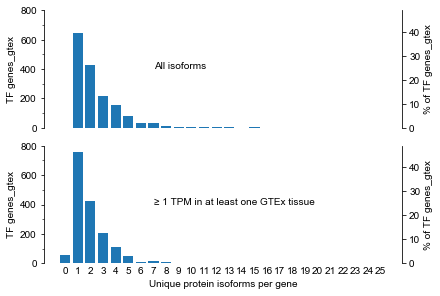

In [224]:
# plot number of isoforms above 1 TPM

fig, axs = plt.subplots(2, 1, sharex=True)

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).size()
x_max = n_iso.max()
xs = range(0, x_max + 1)
axs[0].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum()
axs[1].bar(x=xs, height=[n_iso.value_counts().to_dict().get(x, 0) for x in xs])

axs[1].set_xticks(xs)
axs[1].set_xlabel('Unique protein isoforms per gene')
axs[0].text(x=7, y=400, s='All isoforms')
axs[1].text(x=7, y=400, s='≥ 1 TPM in at least one GTEx tissue')

def num2pct(y):
    return (y / n_iso.shape[0]) * 100

def pct2num(y):
    return (y / 100) * n_iso.shape[0]

for ax in axs:
    ax.set_ylim(0, 800)
    ax.set_yticks(range(0, 800, 100), minor=True)
    ax.set_ylabel('TF genes_gtex')
    for pos in ['top', 'right', 'bottom']:
        ax.spines[pos].set_visible(False)
    ax.xaxis.set_tick_params(length=0)
    pctax = ax.secondary_yaxis('right', functions=(num2pct, pct2num))
    pctax.set_ylabel('% of TF genes_gtex')
    pctax.set_yticks(range(0, 46, 5), minor=True)
fig.savefig('../figures/n-isoforms-per-gene_by-1TPM-cutoff_hist.pdf',
            bbox_inches='tight')

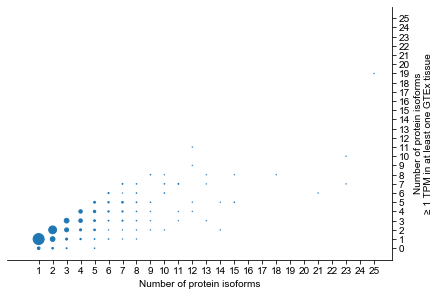

In [225]:
# plot 2D
n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum().rename('tpm').to_frame()
n_iso['n'] = (means_gtex > 1).any(axis=1).groupby(genes_gtex).size()
xy_max = n_iso['n'].max()
pos = [(x, y) for x in range(xy_max + 1) for y in range(xy_max + 1)]
vals = [((n_iso['n'] == x) & (n_iso['tpm'] == y)).sum() for x, y in pos]
fig, ax = plt.subplots(1, 1)
ax.scatter(x=[x for x, _y in pos],
           y=[y for _x, y in pos],
           s=[v * 0.2 for v in vals])
ax.set_xticks(range(1, 26))
ax.set_yticks(range(0, 26))
ax.set_xlabel('Number of protein isoforms')
ax.set_ylabel('Number of protein isoforms\n≥ 1 TPM in at least one GTEx tissue')
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
for pos in ['top', 'left']:
    ax.spines[pos].set_visible(False)
fig.savefig('../figures/n_isoforms-vs-n-gte1TPM_circle-plot.pdf',
            bbox_inches='tight')

In [226]:
# fraction of alternative isoforms
sum(hasattr(tf.orfs[0], 'is_MANE_select_transcript') for tf in tfs.values())

1585

In [227]:
n_iso = (means_gtex > 1).any(axis=1).groupby(genes_gtex).sum()

In [228]:
means_gtex.loc[~means_gtex.index.isin(all_isos), :]

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
UID,,,,,,,,,,,,,,,,,,,,,
AC006213.1-202_AC006213.1-203_AC006213.1-204_AC006213.1-205,1.063981,0.817242,1.074797,0.788774,0.843120,0.723411,1.182261,0.350543,0.439549,0.501748,...,0.760945,0.824487,0.760564,0.629884,0.666178,1.459350,1.336412,1.331729,0.949231,0.135871
AC073611.1-201_AC073611.1-202,0.410068,0.030362,0.009341,0.028268,0.033193,0.027859,0.008505,0.191435,0.233426,0.233956,...,0.056883,0.051219,0.027474,0.032640,0.010125,1.080570,0.396088,0.066303,0.040747,0.012268
ADNP-201_ADNP-202_ADNP-203_ADNP-204_ADNP-205,9.359203,8.411615,8.776267,9.686294,9.531190,9.804328,11.325344,4.826851,5.860329,5.982745,...,9.299609,9.873043,9.451032,9.448751,7.816435,12.669010,10.083925,10.540845,9.766176,2.744589
AHDC1-201_AHDC1-202_AHDC1-206_AHDC1-207_AHDC1-213,8.649284,6.599926,10.390094,10.811389,9.430693,12.468392,10.884813,4.709010,5.961302,5.957258,...,11.521704,12.440537,6.352035,9.329346,6.315706,8.404444,11.726110,12.638761,11.735446,1.212363
AKNA-202_AKNA-206,5.267258,4.851140,1.926136,4.106838,3.897692,3.875296,4.882514,1.636489,1.764671,2.266239,...,2.207562,2.724210,6.007476,7.971003,3.515855,3.039848,3.644299,6.976908,4.105439,7.575926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZSCAN4-201_ZSCAN4-202,0.541682,0.453134,0.215106,0.351052,0.454559,0.440006,1.363873,0.133572,0.149998,0.175418,...,0.961977,0.756923,0.489954,0.555539,0.479945,0.989640,0.782390,0.640003,0.628184,0.124199
ZSCAN5A-201_ZSCAN5A-205,0.688865,0.785956,0.872823,0.611172,0.688289,0.648117,1.005336,0.519651,0.738809,1.152014,...,0.792091,0.792082,0.696267,0.755365,0.487117,4.390352,1.335166,1.193976,0.966753,0.090736
ZSCAN5B-201_ZSCAN5B-202,0.041540,0.047788,0.044860,0.038805,0.042661,0.035107,0.091231,0.133200,0.106414,0.213941,...,0.060276,0.064053,0.054638,0.072947,0.035203,2.320439,0.087719,0.069428,0.068668,0.012108


1300 out of 2094 (62%) alternative isoforms ≥ 1 TPM in at least one tissue
581 out of 2094 (28%) alternative isoforms ≥ 5 TPM in at least one tissue
1004 out of 1084 (93%) MANE select isoforms ≥ 1 TPM in at least one tissue
728 out of 1084 (67%) MANE select isoforms ≥ 5 TPM in at least one tissue


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


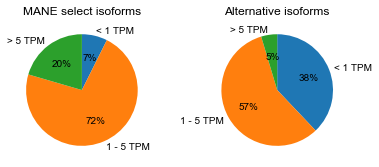

In [229]:
p = (means_gtex.loc[means_gtex.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_gtex.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../figures/GTEx-max-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

1185 out of 2094 (57%) alternative isoforms ≥ 1 TPM in at least one tissue
521 out of 2094 (25%) alternative isoforms ≥ 5 TPM in at least one tissue
956 out of 1084 (88%) MANE select isoforms ≥ 1 TPM in at least one tissue
673 out of 1084 (62%) MANE select isoforms ≥ 5 TPM in at least one tissue


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


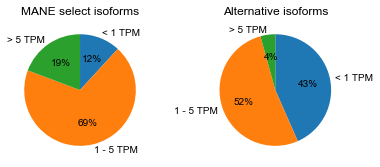

In [230]:
# Exlclude testis
cols = [c for c in means_gtex.columns if c != 'Testis']
p = (means_gtex.loc[means_gtex.index.isin(alt_isos), cols] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(alt_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), cols] >= 1).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (means_gtex.loc[means_gtex.index.isin(ref_isos), cols] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_gtex.loc[:, cols].max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../figures/GTEx-max-expression_by-reference-vs-alternative_no-testis_pie.pdf',
            bbox_inches='tight')

1727 out of 2094 (82%) alternative isoforms ≥ 1 TPM in at least one tissue/dev stage
1060 out of 2094 (51%) alternative isoforms ≥ 5 TPM in at least one tissue/dev stage
1044 out of 1084 (96%) MANE select isoforms ≥ 1 TPM in at least one tissue/dev stage
911 out of 1084 (84%) MANE select isoforms ≥ 5 TPM in at least one tissue/dev stage


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:35: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


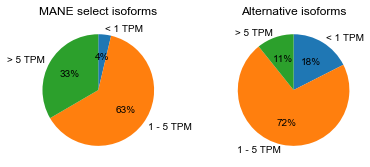

In [231]:
p = (means_dev.loc[means_dev.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = means_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = means_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue/dev stage')

p = (means_dev.loc[means_dev.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = means_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue/dev stage')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = means_dev.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../figures/developmental-max-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

In [232]:
# TODO: move this cell
#means_gtex_downsample = df_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean()

In [233]:
# p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
# n = means_gtex_downsample.index.isin(alt_isos).sum()
# print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

# p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
# n = means_gtex_downsample.index.isin(alt_isos).sum()
# print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

# p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
# n = means_gtex_downsample.index.isin(ref_isos).sum()
# print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

# p = (means_gtex_downsample.loc[means_gtex_downsample.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
# n = means_gtex_downsample.index.isin(ref_isos).sum()
# print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# # pie chart
# fig, axs = plt.subplots(1, 2)
# max_vals = means_gtex_downsample.max(axis=1)

# for isos, ax in zip([ref_isos, alt_isos], axs):
#     ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
#                 ((max_vals[max_vals.index.isin(isos)] >= 1) &
#                 (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
#                 (max_vals[max_vals.index.isin(isos)] > 5).sum()
#                 ],
#             labels=['< 1 TPM',
#                     '1 - 5 TPM',
#                     '> 5 TPM'],
#             counterclock=False,
#             startangle=90,
#             autopct='%.0f%%')
# axs[0].set_title('MANE select isoforms')
# axs[1].set_title('Alternative isoforms')
# plt.subplots_adjust(wspace=0.4)
# fig.savefig('../figures/downsampled-GTEx-control-max-expression_by-reference-vs-alternative_pie.pdf',
#             bbox_inches='tight')

In [234]:
# Apologies for the confusing code here
# getting the 3rd highest sample per isoform per tissue/dev timepoint

def third_highest(data):
    if data.shape[0] < 3:
        return np.nan
    return list(sorted(data, reverse=True))[2]

third_gtex = (df_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
                     .apply(lambda x: x.apply(third_highest, axis=1)))
third_dev = (df_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
                     .apply(lambda x: x.apply(third_highest, axis=1)))

In [235]:
third_dev.notnull().sum(axis=1)

UID
AC006213.1-202_AC006213.1-203_AC006213.1-204_AC006213.1-205    57
AC008554.1-202                                                 57
AC008554.1-205                                                 57
AC008770.2-201                                                 57
AC008770.2-202                                                 57
                                                               ..
ZUP1-202                                                       57
ZXDA-201                                                       57
ZXDB-201                                                       57
ZXDC-201                                                       57
ZXDC-202                                                       57
Length: 4144, dtype: int64

1793 out of 2094 (86%) alternative isoforms ≥ 1 TPM in at least one tissue
1143 out of 2094 (55%) alternative isoforms ≥ 5 TPM in at least one tissue
1060 out of 1084 (98%) MANE select isoforms ≥ 1 TPM in at least one tissue
915 out of 1084 (84%) MANE select isoforms ≥ 5 TPM in at least one tissue


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


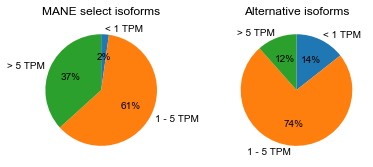

In [236]:
# try requiring at least two samples in the same datapoint to reach the expression threshold
p = (third_gtex.loc[third_gtex.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = third_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (third_gtex.loc[third_gtex.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = third_gtex.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (third_gtex.loc[third_gtex.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = third_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (third_gtex.loc[third_gtex.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = third_gtex.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = third_gtex.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../figures/GTEx-max-third-highest-sample-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

1378 out of 2094 (66%) alternative isoforms ≥ 1 TPM in at least one tissue
769 out of 2094 (37%) alternative isoforms ≥ 5 TPM in at least one tissue
979 out of 1084 (90%) MANE select isoforms ≥ 1 TPM in at least one tissue
807 out of 1084 (74%) MANE select isoforms ≥ 5 TPM in at least one tissue


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:36: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


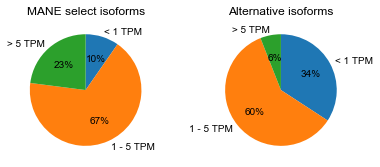

In [237]:
# try requiring at least two samples in the same datapoint to reach the expression threshold
p = (third_dev.loc[third_dev.index.isin(alt_isos), :] >= 1).any(axis=1).sum()
n = third_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 1 TPM in at least one tissue')

p = (third_dev.loc[third_dev.index.isin(alt_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = third_dev.index.isin(alt_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) alternative isoforms ≥ 5 TPM in at least one tissue')

p = (third_dev.loc[third_dev.index.isin(ref_isos), :] >= 1).any(axis=1).sum()
n = third_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 1 TPM in at least one tissue')

p = (third_dev.loc[third_dev.index.isin(ref_isos), :] >= np.log2(5 + 1)).any(axis=1).sum()
n = third_dev.index.isin(ref_isos).sum()
print(f'{p} out of {n} ({p/n:.0%}) MANE select isoforms ≥ 5 TPM in at least one tissue')

# pie chart
fig, axs = plt.subplots(1, 2)
max_vals = third_dev.max(axis=1)

for isos, ax in zip([ref_isos, alt_isos], axs):
    ax.pie([(max_vals[max_vals.index.isin(isos)] < 1).sum(),
                ((max_vals[max_vals.index.isin(isos)] >= 1) &
                (max_vals[max_vals.index.isin(isos)] <= 5)).sum(),
                (max_vals[max_vals.index.isin(isos)] > 5).sum()
                ],
            labels=['< 1 TPM',
                    '1 - 5 TPM',
                    '> 5 TPM'],
            counterclock=False,
            startangle=90,
            autopct='%.0f%%')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
plt.subplots_adjust(wspace=0.4)
fig.savefig('../figures/developmental-max-third-highest-sample-expression_by-reference-vs-alternative_pie.pdf',
            bbox_inches='tight')

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  


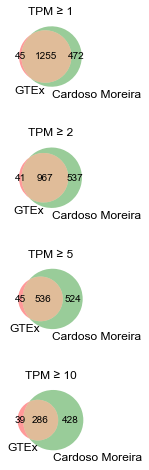

In [238]:
# overlap between tissue and development
# need to deal with adult tissues in development data
from matplotlib_venn import venn2, venn3
tpm_thresholds = [1, 2, 5, 10]
fig, axs = plt.subplots(len(tpm_thresholds), 1)
fig.set_size_inches(w=2, h=2 * len(tpm_thresholds))
for tpm_threshold, ax in zip(tpm_thresholds, axs):
    a = set(means_gtex[(means_gtex.max(axis=1) >= np.log2(tpm_threshold + 1)) &
                    means_gtex.index.isin(alt_isos)].index.values)
    b = set(means_dev[(means_dev.max(axis=1) >= np.log2(tpm_threshold + 1)) &
                    means_dev.index.isin(alt_isos)].index.values)
    venn2([a, b], set_labels=['GTEx', 'Cardoso Moreira'], ax=ax)
    ax.set_title(f'TPM ≥ {tpm_threshold}')
plt.subplots_adjust(hspace=0.7)
fig.savefig('../figures/expressed-alt-isoform-overlap-by-TPM-threshold_Venn.pdf',
            bbox_inches='tight')

In [239]:
metadata_dev['dev_stage'].value_counts()

08             24
11             20
07             20
infant         18
young adult    18
13             18
10             18
16             17
neonate        16
04             16
09             16
19             16
adolescent     14
05             13
12             13
06             13
18             11
toddler        11
elderly         7
adult           7
child           7
Name: dev_stage, dtype: int64

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


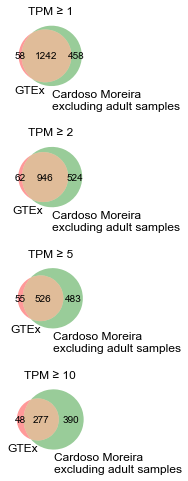

In [240]:
# remove adult tissues in development data
to_exclude = {'young adult', 'adult', 'elderly'}
df_dev.loc[:, df_dev.columns.map(~metadata_dev['dev_stage'].isin(to_exclude))]
means_dev_restricted = (df_dev.loc[:, df_dev.columns.map(~metadata_dev['dev_stage'].isin(to_exclude))].groupby(df_dev.loc[:, df_dev.columns.map(~metadata_dev['dev_stage'].isin(to_exclude))].columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']), axis=1)
           .mean())

tpm_thresholds = [1, 2, 5, 10]
fig, axs = plt.subplots(len(tpm_thresholds), 1)
fig.set_size_inches(w=2, h=2 * len(tpm_thresholds))
for tpm_threshold, ax in zip(tpm_thresholds, axs):
    a = set(means_gtex[(means_gtex.max(axis=1) >= np.log2(tpm_threshold + 1)) &
                    means_gtex.index.isin(alt_isos)].index.values)
    b = set(means_dev_restricted[(means_dev_restricted.max(axis=1) >= np.log2(tpm_threshold + 1)) &
                    means_dev_restricted.index.isin(alt_isos)].index.values)
    venn2([a, b], set_labels=['GTEx', 'Cardoso Moreira\nexcluding adult samples'], ax=ax)
    ax.set_title(f'TPM ≥ {tpm_threshold}')
plt.subplots_adjust(hspace=0.7)
fig.savefig('../figures/expressed-alt-isoform-overlap-restricted-by-TPM-threshold_Venn.pdf',
            bbox_inches='tight')

In [241]:
(df_gtex.shape, df_dev.shape)

((4144, 2485), (4144, 313))

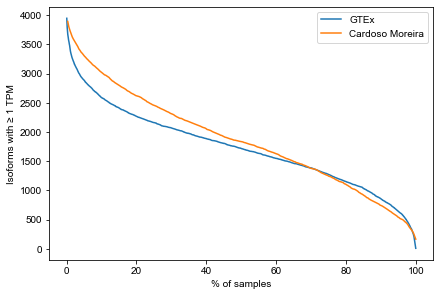

In [242]:
n_samples_gtex = df_gtex.shape[1]
n_samples_gt1_gtex = (df_gtex >= 1).sum(axis=1)
n_samples_dev = df_dev.shape[1]
n_samples_gt1_dev = (df_dev >= 1).sum(axis=1)

fig, ax = plt.subplots(1, 1)
ax.plot([i / n_samples_gtex * 100 for i in range(1, n_samples_gtex + 1)],
        [(n_samples_gt1_gtex >= i).sum() for i in range(1, n_samples_gtex + 1)],
        label='GTEx')
ax.plot([i / n_samples_dev * 100 for i in range(1, n_samples_dev + 1)],
        [(n_samples_gt1_dev >= i).sum() for i in range(1, n_samples_dev + 1)],
        label='Cardoso Moreira')
ax.legend()
ax.set_ylabel('Isoforms with ≥ 1 TPM')
ax.set_xlabel('% of samples')
fig.savefig('../figures/n-isoforms-vs-pct-samples_GTEx-vs-development_line-plot.pdf',
            bbox_inches='tight')

In [243]:
# is this difference just individual level variation?
(df_gtex.max(axis=1) > 1).value_counts()

True     3947
False     197
dtype: int64

In [244]:
# is it possible to partition tissue and developmental stage specific isoforms?
# can I do this within the cardoso morosia data?

In [245]:
(df_dev.max(axis=1) > 1).value_counts()

True     3893
False     251
dtype: int64

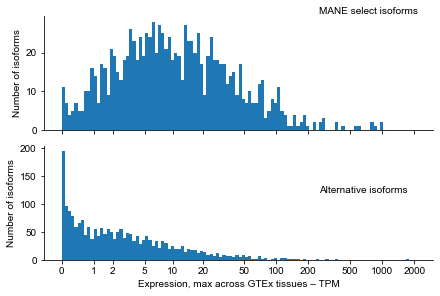

In [246]:
# plot distribution of isoforms by TPM
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[1].hist(means_gtex.max(axis=1)[means_gtex.index.isin(alt_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].hist(means_gtex.max(axis=1)[means_gtex.index.isin(ref_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=30, s='MANE select isoforms')
axs[1].text(x=8, y=120, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across GTEx tissues – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../figures/expression_GTEX_GENCODE-isoforms_by-reference-vs-alternative.pdf',
            bbox_inches='tight')

In [247]:
# # plot distribution of isoforms by TPM
# fig, axs = plt.subplots(2, 1, sharex=True)
# n_bins = 110
# x_max = 11
# axs[1].hist(means_gtex_downsample.max(axis=1)[means_gtex_downsample.index.isin(alt_isos)],
#             bins=n_bins,
#             range=(0, x_max))
# axs[0].hist(means_gtex_downsample.max(axis=1)[means_gtex_downsample.index.isin(ref_isos)],
#             bins=n_bins,
#             range=(0, x_max))
# axs[0].text(x=8, y=axs[0].get_ylim()[1] * 0.95, s='MANE select isoforms')
# axs[1].text(x=8, y=axs[1].get_ylim()[1] * 0.95, s='Alternative isoforms')
# for ax in axs:
#     ax.set_ylabel('Number of isoforms')
#     for loc in ['top', 'right']:
#         ax.spines[loc].set_visible(False)
# axs[1].set_xlabel('Expression, max across GTEx tissues – TPM')
# x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
# axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
# axs[1].set_xticklabels(x_ticks)
# fig.savefig('../figures/expression_downsampled-GTEX-control_GENCODE-isoforms_by-reference-vs-alternative.pdf',
#             bbox_inches='tight')

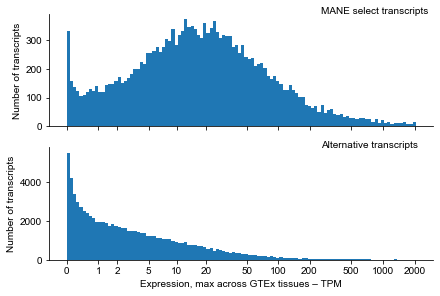

In [248]:
# include all genes

from data_loading import DATA_DIR


def load_gtex_gencode_all_genes():
    """
    NOTE: not summing up the transcripts with identical CDS
    
    """
    df = pd.read_csv(
        DATA_DIR / "processed/expression_2022-09-01/transcript.GTEx-GC30_Isoforms.txt",
        sep="\t",
    )
    metadata = pd.read_csv(
        DATA_DIR / "processed/gtex_2022/GTEx_SRARunTable.txt", sep="\t"
    )
    if metadata["Run"].duplicated().any():
        raise UserWarning("Unexpected duplicates")
    metadata = metadata.set_index("Run")
    df = df.set_index("UID")
    df = (df + 1.0).apply(np.log2)

    def extract_ensembl_gene_id(s):
        return s.split("|")[1].split(".")[0]

    genes = pd.Series(
        index=df.index,
        data=df.index.map(extract_ensembl_gene_id).values,
    )
    df.index = df.index.map(lambda x: x.split('|')[0].split('.')[0])
    genes.index = genes.index.map(lambda x: x.split('|')[0].split('.')[0])
    return df, metadata, genes

df_gtex_all, metadata_gtex_all, genes_gtex_all = load_gtex_gencode_all_genes()
df_gtex_all = df_gtex_all.loc[:, ~df_gtex_all.columns.map(metadata_gtex['body_site']).isin(exclusion_list_gtex)]
metadata_gtex_all = metadata_gtex_all.loc[~metadata_gtex_all['body_site'].isin(exclusion_list_gtex), :]
means_gtex_all = df_gtex_all.groupby(df_gtex_all.columns.map(metadata_gtex_all['body_site']), axis=1).mean()

path_MANE_select=DATA_DIR / "external/MANE.GRCh38.v0.95.summary.txt"
mane = pd.read_csv(path_MANE_select, sep="\t")
mane_select = set(
    mane.loc[mane["MANE_status"] == "MANE Select", "Ensembl_nuc"]
    .str.slice(0, 15)
    .values
)

fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[0].hist(means_gtex_all.max(axis=1)[means_gtex_all.index.isin(mane_select)],
            bins=n_bins,
            range=(0, x_max))
axs[1].hist(means_gtex_all.max(axis=1)[~means_gtex_all.index.isin(mane_select)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=axs[0].get_ylim()[1], s='MANE select transcripts')
axs[1].text(x=8, y=axs[1].get_ylim()[1], s='Alternative transcripts')
for ax in axs:
    ax.set_ylabel('Number of transcripts')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across GTEx tissues – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../figures/expression_GTEX_GENCODE-transcripts_by-reference-vs-alternative-for-all-genes-not-just-TFs.pdf',
            bbox_inches='tight')

In [249]:
means_gtex_all.max(axis=1)[~means_gtex_all.index.isin(mane_select)]

UID
ENST00000335137     0.019545
ENST00000420190     2.024814
ENST00000437963     1.959026
ENST00000342066     0.690161
ENST00000618181     0.166013
                     ...    
ENST00000361335    15.180062
ENST00000361381    15.699318
ENST00000361567    13.067829
ENST00000361681    13.723324
ENST00000361789    15.079208
Length: 81651, dtype: float64

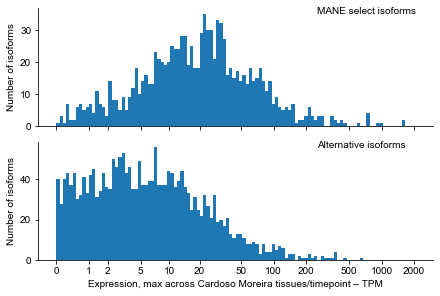

In [250]:
# plot distribution of isoforms by TPM
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[1].hist(means_dev.max(axis=1)[means_dev.index.isin(alt_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].hist(means_dev.max(axis=1)[means_dev.index.isin(ref_isos)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=axs[0].get_ylim()[1] * 0.95, s='MANE select isoforms')
axs[1].text(x=8, y=axs[1].get_ylim()[1] * 0.95, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across Cardoso Moreira tissues/timepoint – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../figures/expression_development_GENCODE-isoforms_by-reference-vs-alternative.pdf',
            bbox_inches='tight')

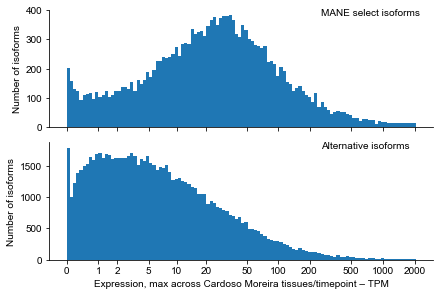

In [251]:
def load_developmental_tissue_expression_gencode_all_genes():
    """
    Cardoso-Moreira et al. Nature


    """
    metadata = pd.read_csv(DATA_DIR / "processed/Cardoso-Moreira_et_al/metadata.txt")
    df = pd.read_csv(
        DATA_DIR
        / "processed/expression_2022-09-01/transcript.Cardoso-Moreira-et-al-Nature-2019-GC30_Isoforms.txt",
        sep="\t",
    )
    if metadata["Run"].duplicated().any():
        raise UserWarning("Unexpected duplicates")
    metadata = metadata.set_index("Run")
    df = df.set_index("UID")
    df = (df + 1.0).apply(np.log2)

    def extract_ensembl_gene_id(s):
        return s.split("|")[1].split(".")[0]

    genes = pd.Series(
        index=df.index,
        data=df.index.map(extract_ensembl_gene_id).values,
    )
   
    genes = genes[~genes.index.duplicated(keep="first")]

    # the file has ERR2598062.fastq.gz instead of ERR2598062
    df.columns = df.columns.str.slice(0, -len(".fastq.gz"))

    if not df.columns.isin(metadata.index).all():
        raise UserWarning("Missing metadata")
    metadata = metadata.loc[metadata.index.isin(df.columns), :]
    df.index = df.index.map(lambda x: x.split('|')[0].split('.')[0])
    genes.index = genes.index.map(lambda x: x.split('|')[0].split('.')[0])
    return df, metadata, genes


df_dev_all, metadata_dev_all, genes_dev_all = load_developmental_tissue_expression_gencode_all_genes()
metadata_dev_all['dev_stage'] = metadata_dev_all['Developmental_Stage'].map(rename_dev_stage)
means_dev_all = (df_dev_all.groupby(df_dev_all.columns.map(metadata_dev_all['organism_part'] + ' ' + metadata_dev_all['dev_stage']), axis=1)
           .mean())

fig, axs = plt.subplots(2, 1, sharex=True)
n_bins = 110
x_max = 11
axs[0].hist(means_dev_all.max(axis=1)[means_dev_all.index.isin(mane_select)],
            bins=n_bins,
            range=(0, x_max))
axs[1].hist(means_dev_all.max(axis=1)[~means_dev_all.index.isin(mane_select)],
            bins=n_bins,
            range=(0, x_max))
axs[0].text(x=8, y=axs[0].get_ylim()[1] * 0.95, s='MANE select isoforms')
axs[1].text(x=8, y=axs[1].get_ylim()[1] * 0.95, s='Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for loc in ['top', 'right']:
        ax.spines[loc].set_visible(False)
axs[1].set_xlabel('Expression, max across Cardoso Moreira tissues/timepoint – TPM')
x_ticks = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
axs[1].set_xticks([np.log2(x + 1) for x in x_ticks])
axs[1].set_xticklabels(x_ticks)
fig.savefig('../figures/expression_development_GENCODE-transcripts_by-reference-vs-alternative-for-all-genes-not-just-TFs.pdf',
            bbox_inches='tight')

In [252]:
(
    means_gtex.loc[means_gtex.index.isin(ref_isos)].max(axis=1).mean(),
    means_dev.loc[means_dev.index.isin(ref_isos)].max(axis=1).mean(),
    means_gtex_all.loc[means_gtex_all.index.isin(mane_select)].max(axis=1).mean(),
    means_dev_all.loc[means_dev_all.index.isin(mane_select)].max(axis=1).mean(),
)

(3.5190036879087487, 4.313855749314403, 4.245403084218637, 4.5703124658168415)

In [253]:
# GAPDH and actin
(
    means_gtex_all.groupby(genes_gtex_all).sum().max(axis=1)['ENSG00000111640'],
    means_dev_all.groupby(genes_dev_all).sum().max(axis=1)['ENSG00000111640'],
    means_gtex_all.groupby(genes_gtex_all).sum().max(axis=1)['ENSG00000075624'],
    means_dev_all.groupby(genes_dev_all).sum().max(axis=1)['ENSG00000075624']

    )

(35.58638346527894, 42.63682806797509, 56.03674976423328, 57.430600990641494)

In [254]:
# number of isoforms vs gene expression, publications, and exons 
tpm_per_gene = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .sum()
                .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
                .mean())
gn = tpm_per_gene.max(axis=1).rename('TPM - gene-level, max across GTEx tissues').to_frame()
gn['n_isoforms'] = gn.index.map(genes_gtex.value_counts())

In [255]:
#from ccsblib.huri import load_number_publications_per_gene, load_id_map

# n_pub = load_number_publications_per_gene().to_frame().reset_index()
# ensembl_to_hgnc = (load_id_map('ensembl_gene_id', 'hgnc_symbol')
#                     .drop_duplicates('ensembl_gene_id')
#                     .set_index('ensembl_gene_id')
#                     ['hgnc_symbol'])
# n_pub['hgnc_symbol'] = n_pub['ensembl_gene_id'].map(lambda x: ensembl_to_hgnc.get(x, np.nan))
# n_pub = n_pub.groupby('hgnc_symbol').sum()['n_pubmed_ids']
# gn['Number of publications'] = gn.index.map(n_pub)

In [256]:
# TODO: change to get reference isoform
gn['Number of exons in reference isoform'] = gn.index.map({name: len(tf.orfs[0].exons) for name, tf in tfs.items()})

In [257]:
gn.head()

,"TPM - gene-level, max across GTEx tissues",n_isoforms,Number of exons in reference isoform
AC008770.3,0.339530,2,4
AC023509.3,4.475325,1,12
AC092835.1,0.884619,1,5
AC138696.1,1.760060,1,1
ADNP,9157.752828,3,3


Text(235304392050.94446, 18, 'rho = 0.18')

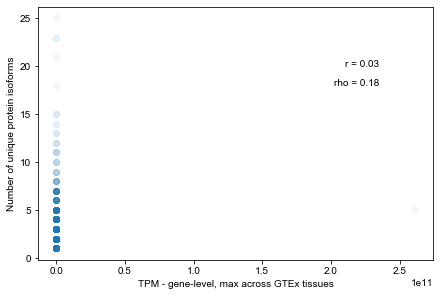

In [258]:
# log-scale?
fig, ax = plt.subplots(1, 1)
x_col = 'TPM - gene-level, max across GTEx tissues'
y_col = 'n_isoforms'
x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values
ax.scatter(x, y, alpha=0.05)
ax.set_ylabel('Number of unique protein isoforms')
ax.set_xlabel(x_col)
r = stats.pearsonr(x, y)[0]
rho = stats.spearmanr(x, y)[0]
ax.text(x=x.max() * 0.9, y=20, s=f'r = {r:.2f}', ha='right')
ax.text(x=x.max() * 0.9, y=18, s=f'rho = {rho:.2f}', ha='right')

In [259]:
import seaborn as sns

# fig, axs = plt.subplots(3, 1, sharex=True)
# fig.set_size_inches(w=8, h=12)

# y_col = 'n_isoforms'
# x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
# y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values

# ax = axs[0]
# x_col = 'TPM - gene-level, max across GTEx tissues'
# sns.boxplot(data=gn, 
#                x='n_isoforms', 
#                y=x_col,
#             ax=ax,
#             color='C0')
# ax.set_yscale('log')
# x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
# y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values
# r = stats.pearsonr(np.log2(x + 1), y)[0]
# rho = stats.spearmanr(x, y)[0]
# ax.text(y=x.max() * 0.9, x=18, s=f'Pearson\'s r = {r:.2f}', ha='right')
# ax.text(y=x.max() * 0.5, x=18, s=f'Spearman\'s rho = {rho:.2f}', ha='right')

# ax = axs[1]
# x_col = 'Number of publications'
# sns.boxplot(data=gn, 
#                x='n_isoforms', 
#                y=x_col,
#                 ax=ax,
#                 color='C0')
# ax.set_yscale('log')
# x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
# y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values
# r = stats.pearsonr(np.log2(x + 1), y)[0]
# rho = stats.spearmanr(x, y)[0]
# ax.text(y=x.max() * 0.9, x=18, s=f'Pearson\'s r = {r:.2f}', ha='right')
# ax.text(y=x.max() * 0.5, x=18, s=f'Spearman\'s rho = {rho:.2f}', ha='right')

# ax = axs[2]
# x_col = 'Number of exons in reference isoform'
# sns.boxplot(data=gn,
#                x='n_isoforms', 
#                y=x_col,
#              ax=ax,
#              color='C0')
# x = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), x_col].values
# y = gn.loc[gn[x_col].notnull() & gn[y_col].notnull(), y_col].values
# r = stats.pearsonr(x, y)[0]
# rho = stats.spearmanr(x, y)[0]
# ax.text(y=x.max() * 0.9, x=18, s=f'Pearson\'s r = {r:.2f}', ha='right')
# ax.text(y=x.max() * 0.8, x=18, s=f'Spearman\'s rho = {rho:.2f}', ha='right')
# fig.savefig('../figures/n-isoforms-vs-expression-publication-n-exons_boxplot.pdf',
#             bbox_inches='tight')

In [260]:
from data_loading import load_tf_families

fam = load_tf_families()
gn['family'] = gn.index.map(fam)
gn['is_nuclear_receptor'] = (gn['family'] == 'Nuclear receptor')

In [261]:
gn['family'].value_counts().head(10)

C2H2 ZF             745
Homeodomain         194
bHLH                108
Unknown              69
bZIP                 54
Forkhead             49
Nuclear receptor     46
HMG/Sox              30
Ets                  27
T-box                17
Name: family, dtype: int64

In [262]:
# fig, ax = plt.subplots(1, 1)
# sns.boxplot(data=gn,
#             x='is_nuclear_receptor',
#             y='Number of publications',
#             ax=ax)
# ax.set_yscale('log')

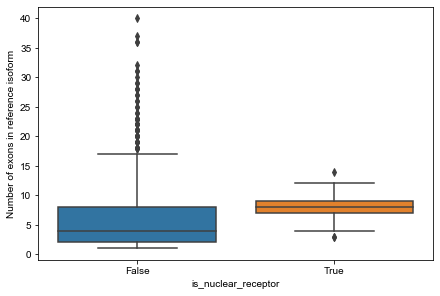

In [263]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=gn,
            x='is_nuclear_receptor',
            y='Number of exons in reference isoform',
            ax=ax)

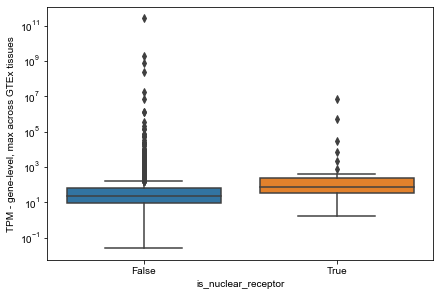

In [264]:
fig, ax = plt.subplots(1, 1)
sns.boxplot(data=gn,
            x='is_nuclear_receptor',
            y='TPM - gene-level, max across GTEx tissues',
            ax=ax)
ax.set_yscale('log')

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


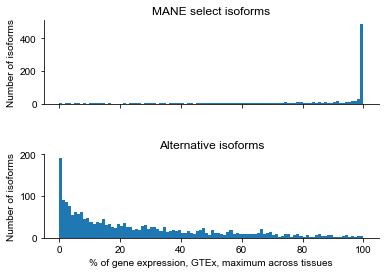

In [265]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins=100
axs[0].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(ref_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(alt_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].set_xlabel('% of gene expression, GTEx, maximum across tissues')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(hspace=0.6)
fig.savefig('../figures/expression-fraction-GTEx-max-across-tissues_ref-vs-alt_hist.pdf',
            bbox_inches='tight')


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:34: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


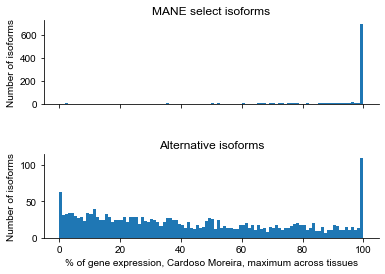

In [266]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= 1)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1

f_dev = f_dev * 100
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins=100
axs[0].hist(f_dev.max(axis=1).loc[f_dev.index.isin(ref_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].hist(f_dev.max(axis=1).loc[f_dev.index.isin(alt_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].set_xlabel('% of gene expression, Cardoso Moreira, maximum across tissues')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(hspace=0.6)
fig.savefig('../figures/expression-fraction-development-max-across-tissues_ref-vs-alt_hist.pdf',
            bbox_inches='tight')


In [267]:
TPM_THRESHOLD = 2
per_gene_dev = ((2 ** df_dev - 1)
                .groupby(genes_dev)
                .transform('sum'))
f_dev = (((2 ** df_dev - 1) / per_gene_dev)
        .groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
         axis=1)
        .mean())
f_dev = f_dev * ((per_gene_dev.groupby(df_dev.columns.map(metadata_dev['organism_part'] + ' ' + metadata_dev['dev_stage']),
                                             axis=1)
                                             .mean() >= TPM_THRESHOLD)
                                         .applymap(lambda x: {False: np.nan, True: 1}[x]))  # only count fractions if gene TPM is >= 1
f_dev = f_dev * 100

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex['body_site']), axis=1).mean() >= TPM_THRESHOLD).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1
f_gtex = f_gtex * 100

# alternative isoform > 50% in dev with corresponding ref iso > 50% in either
# plus some magnitude of change?
putative_switching_alt_isos = set(f_dev.loc[f_dev.index.isin(alt_isos) &
                                           (f_dev.max(axis=1) > 50), :].index.values)
print(len(putative_switching_alt_isos))
valid_ref_isos = (set(f_dev.loc[f_dev.index.isin(ref_isos) &
                               (f_dev.max(axis=1) > 50), :].index.values)
                        .union(
                  set(f_gtex.loc[f_gtex.index.isin(ref_isos) &
                               (f_gtex.max(axis=1) > 50), :].index.values)
                        ))
if not (genes_gtex == genes_dev).all():
        raise UserWarning()
genes = genes_gtex
genes_with_valid_ref_isos = {genes[iso] for iso in valid_ref_isos}
switching_alt_isos = {iso for iso in putative_switching_alt_isos if genes[iso] in genes_with_valid_ref_isos}
print(len(switching_alt_isos))

729
449


### note to luke - this block of code seems to finish correctly only sometimes, something about the .sample() step

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


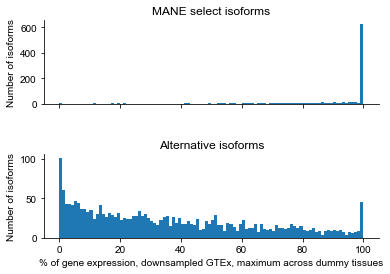

In [268]:
# percentage of alternative isoform
# plot distribution of fraction of gene expression for ref and alt

# has to be fraction where isoform TPM is at least 1, right (fill na with 0)

per_gene_gtex = ((2 ** df_gtex - 1)
                .groupby(genes_gtex)
                .transform('sum'))
f_gtex = (((2 ** df_gtex - 1) / per_gene_gtex)
        .groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1)
        .mean())
f_gtex = f_gtex * (per_gene_gtex.groupby(df_gtex.columns.map(metadata_gtex_dummy['body_site']), axis=1).mean() >= 1).applymap(lambda x: {False: np.nan, True: 1}[x])  # only count fractions if gene TPM is >= 1

f_gtex = f_gtex * 100
fig, axs = plt.subplots(2, 1, sharex=True)
n_bins=100
axs[0].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(ref_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].hist(f_gtex.max(axis=1).loc[f_gtex.index.isin(alt_isos)].values,
            range=(0, 100),
            bins=n_bins)
axs[1].set_xlabel('% of gene expression, downsampled GTEx, maximum across dummy tissues')
axs[0].set_title('MANE select isoforms')
axs[1].set_title('Alternative isoforms')
for ax in axs:
    ax.set_ylabel('Number of isoforms')
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
plt.subplots_adjust(hspace=0.6)
fig.savefig('../figures/expression-fraction-downsampled-GTEx-control-max-across-tissues_ref-vs-alt_hist.pdf',
            bbox_inches='tight')


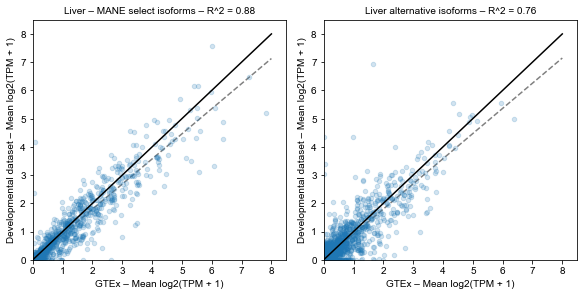

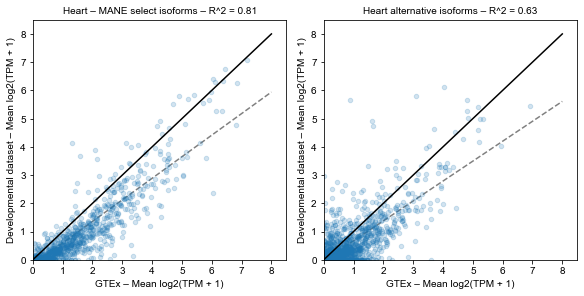

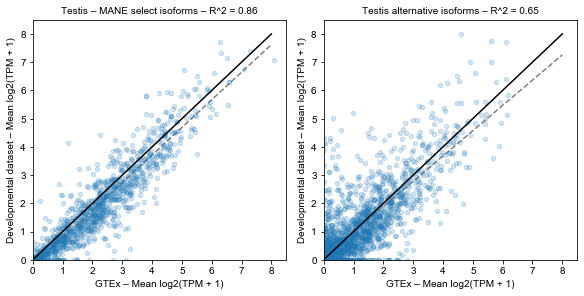

In [269]:
# TODO: diagonal line
# Comparing adult samples between GTEx and develpment
import statsmodels.api as sm
paired_tissues = [('liver adult', 'Liver'),
                  ('heart young adult', 'Heart - Atrial Appendage'),
                  ('testis adult', 'Testis')]
for cm_tissue, gtex_tissue in paired_tissues:
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(w=8, h=4)
    paired = pd.merge(means_dev.loc[:, [cm_tissue]],
                      means_gtex.loc[:, [gtex_tissue]],
            how='inner',
            left_index=True, right_index=True)
    (paired.loc[paired.index.isin(ref_isos), :]
    .plot.scatter(x=gtex_tissue, 
                        y=cm_tissue, 
                        alpha=0.2,
                        ax=axs[0]))
    upper = 8
    #upper = paired.max().max()
    r = paired.loc[paired.index.isin(ref_isos), :].corr().loc[cm_tissue, gtex_tissue]

    x = paired.loc[paired.index.isin(ref_isos), gtex_tissue].values
    y = paired.loc[paired.index.isin(ref_isos), cm_tissue].values
    intercept, slope = sm.OLS(y, sm.add_constant(x)).fit().params
    axs[0].plot(range(upper + 1), [intercept + slope * x for x in range(upper + 1)], '--', color='grey', zorder=-1)

    axs[0].set_title('{} – MANE select isoforms – R^2 = {:.2f}'.format(gtex_tissue.split()[0], r**2),
                    fontsize=10)
    (paired.loc[paired.index.isin(alt_isos), :]
    .plot.scatter(x=gtex_tissue, 
                        y=cm_tissue, 
                        alpha=0.2,
                        ax=axs[1]))
    r = paired.loc[paired.index.isin(alt_isos), :].corr().loc[cm_tissue, gtex_tissue]
    x = paired.loc[paired.index.isin(alt_isos), gtex_tissue].values
    y = paired.loc[paired.index.isin(alt_isos), cm_tissue].values
    intercept, slope = sm.OLS(y, sm.add_constant(x)).fit().params
    axs[1].plot(range(upper + 1), [intercept + slope * x for x in range(upper + 1)], '--', color='grey', zorder=-1)
    axs[1].set_title('{} alternative isoforms – R^2 = {:.2f}'.format(gtex_tissue.split()[0], r**2),
                     fontsize=10)

    for ax in axs:
        ax.set_ylim(0, upper + 0.5)
        ax.set_xlim(0, upper + 0.5)
        ax.set_yticks(range(0, int(upper+1)))
        ax.set_xticks(range(0, int(upper+1)))
        ax.plot([0, upper], [0, upper], '-', color='black')
        ax.set_xlabel('GTEx – Mean log2(TPM + 1)')
        ax.set_ylabel('Developmental dataset – Mean log2(TPM + 1)')
    plt.savefig('../figures/GTEx-vs-dev_{}_GENCODE.pdf'.format(gtex_tissue), bbox_inches='tight')


In [270]:
# calculate tissue-specificity score for each isoform
def calculate_tiss_spec(x):
    # assumes input of a row of only the tissue expression data
    med = x.median() 
    iqr = x.quantile(0.75) - x.quantile(0.25)
    for tiss in x.index:
        score = (x[tiss] - med) / float(iqr)
        x[tiss] = score
    x['max_tip'] = x.max()
    return x

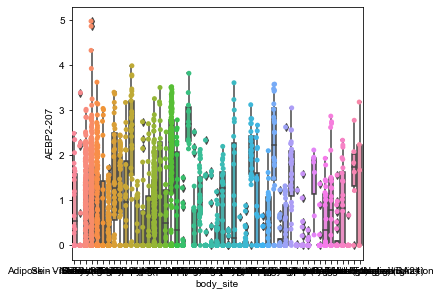

In [271]:
# dot / box plot
df = df_gtex.T.copy()
isoform = 'AEBP2-207'
df['body_site'] = df.index.map(metadata_gtex['body_site'])
sns.boxplot(data=df, x='body_site', y=isoform)
sns.stripplot(data=df, x='body_site', y=isoform)

### kaia's new plots

In [272]:
ref_alt_map = pd.DataFrame([ref_isos]).T
ref_alt_map.columns = ["ref"]
ref_alt_map["gene"] = ref_alt_map["ref"].str.split("|", expand=True)[0].str[:-4]

alt_isos_df = pd.DataFrame([alt_isos]).T
alt_isos_df.columns = ["alt"]
alt_isos_df["gene"] = alt_isos_df["alt"].str.split("|", expand=True)[0].str[:-4]

ref_alt_map = ref_alt_map.merge(alt_isos_df, on="gene", how="left")
print(len(ref_alt_map))
ref_alt_map_nonan = ref_alt_map[~pd.isnull(ref_alt_map["alt"])]
print(len(ref_alt_map_nonan))
ref_alt_map_nonan.head()

2910
2305


,ref,gene,alt
0,ZNF93-201,ZNF93,ZNF93-205
1,ZNF93-201,ZNF93,ZNF93-209
2,ZNF93-201,ZNF93,ZNF93-206
4,ZNF614-201,ZNF614,ZNF614-202
6,CREB5-201,CREB5,CREB5-203|CREB5-205


In [273]:
ref_alt_map_nonan[ref_alt_map_nonan["gene"] == "NKX2-5"]

,ref,gene,alt
50,NKX2-5-201,NKX2-5,NKX2-5-202
51,NKX2-5-201,NKX2-5,NKX2-5-204


In [274]:
means_dev["max_dev"] = means_dev.max(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_dev[means_dev["max_dev"] > 11] = 11

print(means_dev["max_dev"].max())
print(means_dev["max_dev"].min())
means_dev_ri = means_dev.reset_index()
means_dev_ri["UID_rep"] = means_dev_ri["UID"].str.replace("_", "|")
means_dev_ri.head()

11.0
0.0


,UID,forebrain 04,forebrain 05,forebrain 07,forebrain 08,forebrain 09,forebrain 10,forebrain 11,forebrain 12,forebrain 13,...,testis 18,testis 19,testis adolescent,testis adult,testis elderly,testis infant,testis toddler,testis young adult,max_dev,UID_rep
0,AC006213.1-202_AC006213.1-203_AC006213.1-204_A...,3.654994,3.494678,3.626530,1.960491,0.597415,1.554181,1.268259,4.026616,2.440453,...,3.533458,1.695945,0.558741,1.648462,0.608820,1.070210,2.016361,1.018453,5.416342,AC006213.1-202|AC006213.1-203|AC006213.1-204|A...
1,AC008554.1-202,2.800765,3.079278,3.730430,3.757059,2.931788,3.701516,2.879375,4.474916,3.217087,...,3.064624,2.158059,1.244521,1.438836,1.330013,2.139744,2.469076,1.425817,4.474916,AC008554.1-202
2,AC008554.1-205,2.335974,2.314422,2.337000,1.743347,0.378943,2.493496,1.339539,2.606726,2.177328,...,1.620103,2.215592,0.450846,0.460070,0.458986,1.108087,2.084394,0.636556,2.856755,AC008554.1-205
3,AC008770.2-201,0.617285,0.862985,0.750227,0.066533,0.054676,0.602899,0.206606,0.402685,0.414440,...,0.603447,0.688648,0.000000,0.000000,0.148760,0.056936,0.000000,0.277994,1.049275,AC008770.2-201
4,AC008770.2-202,0.000000,0.000000,0.143134,0.258975,0.000000,0.000000,0.107577,0.000000,0.000000,...,0.000000,0.000000,0.299295,0.204483,0.000000,0.000000,0.000000,0.229587,0.867296,AC008770.2-202


In [275]:
means_gtex["max_gtex"] = means_gtex.max(axis=1)

# max out anything above 11 (2000 tpm) to make plots more readable, as luke did above
means_gtex[means_gtex["max_gtex"] > 11] = 11

print(means_gtex["max_gtex"].max())
print(means_gtex["max_gtex"].min())
means_gtex_ri = means_gtex.reset_index()
means_gtex_ri["UID_rep"] = means_gtex_ri["UID"].str.replace("_", "|")
means_gtex_ri.head()

11.0
0.0


,UID,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),...,Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood,max_gtex,UID_rep
0,AC006213.1-202_AC006213.1-203_AC006213.1-204_A...,1.063981,0.817242,1.074797,0.788774,0.843120,0.723411,1.182261,0.350543,0.439549,...,0.760564,0.629884,0.666178,1.459350,1.336412,1.331729,0.949231,0.135871,2.706939,AC006213.1-202|AC006213.1-203|AC006213.1-204|A...
1,AC008554.1-202,1.214610,1.187586,2.124960,1.219388,1.337562,1.158947,2.080296,0.798995,1.003003,...,1.513697,1.652043,1.237348,1.632115,2.862366,1.799571,1.621737,0.470699,2.862366,AC008554.1-202
2,AC008554.1-205,1.247521,0.896456,1.458095,0.838977,0.715022,0.669437,1.445944,0.390527,0.469839,...,1.111679,1.150330,0.653358,1.078596,2.070581,1.141930,1.197968,0.435525,2.070581,AC008554.1-205
3,AC008770.2-201,0.123205,0.010852,0.041878,0.039307,0.093006,0.152886,0.052743,0.014297,0.021424,...,0.078722,0.022685,0.042440,0.058371,0.044181,0.044235,0.033999,0.004024,0.152886,AC008770.2-201
4,AC008770.2-202,0.113983,0.058187,0.052925,0.083813,0.080161,0.097036,0.101938,0.018507,0.011019,...,0.037602,0.074077,0.076769,0.345484,0.100225,0.071313,0.098427,0.036673,0.345484,AC008770.2-202


In [276]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_gtex_ri[["UID_rep", "max_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(means_dev_ri[["UID_rep", "max_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")
print(len(ref_alt_map_nonan))

ref_alt_map_nonan.head()

2305


,ref,gene,alt,UID_rep_ref,max_gtex_ref,UID_rep_alt,max_gtex_alt,UID_rep_ref,max_dev_ref,UID_rep_alt,max_dev_alt
0,ZNF93-201,ZNF93,ZNF93-205,ZNF93-201,2.103667,ZNF93-205,1.188165,ZNF93-201,4.691125,ZNF93-205,3.845396
1,ZNF93-201,ZNF93,ZNF93-209,ZNF93-201,2.103667,ZNF93-209,0.008433,ZNF93-201,4.691125,ZNF93-209,0.502903
2,ZNF93-201,ZNF93,ZNF93-206,ZNF93-201,2.103667,ZNF93-206,1.657588,ZNF93-201,4.691125,ZNF93-206,2.532621
3,ZNF614-201,ZNF614,ZNF614-202,ZNF614-201,2.775876,ZNF614-202,3.189324,ZNF614-201,4.197000,ZNF614-202,3.504154
4,CREB5-201,CREB5,CREB5-203|CREB5-205,CREB5-201,2.776639,CREB5-203|CREB5-205,0.036232,CREB5-201,5.144161,CREB5-203|CREB5-205,0.830569


In [277]:
ref_alt_map_nonan.sort_values(by="max_gtex_ref", ascending=False).head()

,ref,gene,alt,UID_rep_ref,max_gtex_ref,UID_rep_alt,max_gtex_alt,UID_rep_ref,max_dev_ref,UID_rep_alt,max_dev_alt
522,GATA3-202|GATA3-206,GATA3,GATA3-201,GATA3-202|GATA3-206,11.0,GATA3-201,5.418910,GATA3-202|GATA3-206,9.904333,GATA3-201,4.891357
2293,NR4A1-201|NR4A1-203|NR4A1-204,NR4A1,NR4A1-209,NR4A1-201|NR4A1-203|NR4A1-204,11.0,NR4A1-209,7.584608,NR4A1-201|NR4A1-203|NR4A1-204,11.000000,NR4A1-209,8.204596
1673,PPARG-202|PPARG-205|PPARG-207|PPARG-209|PPARG-...,PPARG,PPARG-218,PPARG-202|PPARG-205|PPARG-207|PPARG-209|PPARG-...,11.0,PPARG-218,0.387110,PPARG-202|PPARG-205|PPARG-207|PPARG-209|PPARG-...,8.229357,PPARG-218,0.880779
2228,PAX6-202|PAX6-207|PAX6-209|PAX6-231|PAX6-243|P...,PAX6,PAX6-238,PAX6-202|PAX6-207|PAX6-209|PAX6-231|PAX6-243|P...,11.0,PAX6-238,0.059011,PAX6-202|PAX6-207|PAX6-209|PAX6-231|PAX6-243|P...,11.000000,PAX6-238,0.582684
2189,ADNP-201|ADNP-202|ADNP-203|ADNP-204|ADNP-205,ADNP,ADNP-207,ADNP-201|ADNP-202|ADNP-203|ADNP-204|ADNP-205,11.0,ADNP-207,3.785105,ADNP-201|ADNP-202|ADNP-203|ADNP-204|ADNP-205,11.000000,ADNP-207,5.748177


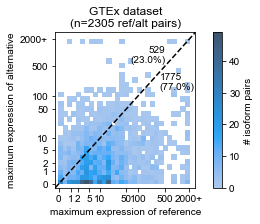

In [278]:
fig = plt.figure(figsize=(3.5, 3))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_gtex_ref", y="max_gtex_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs"})

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("maximum expression of reference")
ax.set_ylabel("maximum expression of alternative")
ax.set_title("GTEx dataset\n(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 2, 5, 10, 50, 100, 500, 2000]
ticklabels = [0, 1, 2, 5, 10, 50, 100, 500, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] > ref_alt_map_nonan["max_gtex_alt"]])
ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_gtex_ref"] < ref_alt_map_nonan["max_gtex_alt"]])
ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../figures/expression-scatter-ref_v_alt-gtex.pdf',
            bbox_inches='tight')

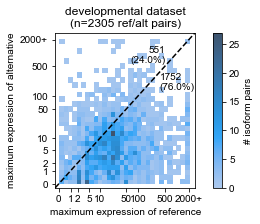

In [279]:
fig = plt.figure(figsize=(3.5, 3))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_dev_ref", y="max_dev_alt",
                  bins=30, cbar=True, cbar_kws={"label": "# isoform pairs"})

ax.set_xlim((-0.3, 11.5))
ax.set_ylim((-0.3, 11.5))
ax.set_xlabel("maximum expression of reference")
ax.set_ylabel("maximum expression of alternative")
ax.set_title("developmental dataset\n(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

ticks = [0, 1, 2, 5, 10, 50, 100, 500, 2000]
ticklabels = [0, 1, 2, 5, 10, 50, 100, 500, "2000+"]
ax.set_xticks([np.log2(x + 1) for x in ticks])
ax.set_xticklabels(ticklabels)
ax.set_yticks([np.log2(y + 1) for y in ticks])
ax.set_yticklabels(ticklabels)

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] > ref_alt_map_nonan["max_dev_alt"]])
ax.text(8.5, 7, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="left", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_dev_ref"] < ref_alt_map_nonan["max_dev_alt"]])
ax.text(9, 10.5, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="right", va="top")

ax.plot([-0.3,11.5], [-0.3, 11.5], color="black", linestyle="dashed")

fig.savefig('../figures/expression-scatter-ref_v_alt-dev.pdf',
            bbox_inches='tight')

In [280]:
# putting NA as 0!
f_dev["max_ratio_dev"] = f_dev.max(axis=1)
f_dev["max_ratio_dev"].fillna(0, inplace=True)
f_dev["min_ratio_dev"] = f_dev.min(axis=1)
f_dev["min_ratio_dev"].fillna(0, inplace=True)
print(f_dev["max_ratio_dev"].max())
print(f_dev["max_ratio_dev"].min())
f_dev_ri = f_dev.reset_index()
f_dev_ri["UID_rep"] = f_dev_ri["UID"].str.replace("_", "|")
f_dev_ri.head()

100.0
0.0


,UID,forebrain 04,forebrain 05,forebrain 07,forebrain 08,forebrain 09,forebrain 10,forebrain 11,forebrain 12,forebrain 13,...,testis 19,testis adolescent,testis adult,testis elderly,testis infant,testis toddler,testis young adult,max_ratio_dev,min_ratio_dev,UID_rep
0,AC006213.1-202_AC006213.1-203_AC006213.1-204_A...,100.000000,100.000000,100.00000,100.000000,NaN,NaN,NaN,100.000000,100.000000,...,100.000000,NaN,100.000000,NaN,NaN,100.000000,NaN,100.000000,100.000000,AC006213.1-202|AC006213.1-203|AC006213.1-204|A...
1,AC008554.1-202,59.650572,65.216814,73.46175,83.965129,95.92311,72.168864,74.858559,80.662853,70.870981,...,48.722682,NaN,81.999244,NaN,76.360792,58.330826,76.416668,98.332129,35.690471,AC008554.1-202
2,AC008554.1-205,40.349428,34.783186,26.53825,16.034871,4.07689,27.831136,25.141441,19.337147,29.129019,...,51.277318,NaN,18.000756,NaN,23.639208,41.669174,23.583332,64.309529,1.667871,AC008554.1-205
3,AC008770.2-201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,AC008770.2-201
4,AC008770.2-202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,AC008770.2-202


In [281]:
# putting NA as 0!
f_gtex["max_ratio_gtex"] = f_gtex.max(axis=1)
f_gtex["max_ratio_gtex"].fillna(0, inplace=True)
f_gtex["min_ratio_gtex"] = f_gtex.min(axis=1)
f_gtex["min_ratio_gtex"].fillna(0, inplace=True)
print(f_gtex["max_ratio_gtex"].max())
print(f_gtex["max_ratio_gtex"].min())
f_gtex_ri = f_gtex.reset_index()
f_gtex_ri["UID_rep"] = f_gtex_ri["UID"].str.replace("_", "|")
f_gtex_ri.head()

100.0
0.0


,UID,Adipose - Subcutaneous_114,Adipose - Subcutaneous_12,Adipose - Subcutaneous_63,Adipose - Visceral (Omentum)_116,Adipose - Visceral (Omentum)_14,Adipose - Visceral (Omentum)_65,Adrenal Gland_106,Adrenal Gland_4,Adrenal Gland_55,...,Uterus_75,Vagina_115,Vagina_13,Vagina_64,Whole Blood_110,Whole Blood_59,Whole Blood_8,max_ratio_gtex,min_ratio_gtex,UID_rep
0,AC006213.1-202_AC006213.1-203_AC006213.1-204_A...,100.000000,100.00000,100.000000,NaN,NaN,NaN,100.000000,NaN,NaN,...,100.000000,NaN,100.000000,NaN,NaN,NaN,NaN,100.000000,100.000000,AC006213.1-202|AC006213.1-203|AC006213.1-204|A...
1,AC008554.1-202,47.276573,48.54218,64.414413,65.332496,44.255282,55.537139,66.340827,71.466116,73.311008,...,62.788868,65.549717,70.857535,64.878983,NaN,NaN,NaN,91.647036,36.182185,AC008554.1-202
2,AC008554.1-205,52.723427,51.45782,35.585587,34.667504,55.744718,44.462861,33.659173,28.533884,26.688992,...,37.211132,34.450283,29.142465,35.121017,NaN,NaN,NaN,63.817815,8.352964,AC008554.1-205
3,AC008770.2-201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,AC008770.2-201
4,AC008770.2-202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,AC008770.2-202


In [282]:
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_gtex_ri[["UID_rep", "max_ratio_gtex", "min_ratio_gtex"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="ref", 
                                            right_on="UID_rep", how="inner")
ref_alt_map_nonan = ref_alt_map_nonan.merge(f_dev_ri[["UID_rep", "max_ratio_dev", "min_ratio_dev"]], left_on="alt", 
                                            right_on="UID_rep", suffixes=("_ref", "_alt"), how="inner")
print(len(ref_alt_map_nonan))
ref_alt_map_nonan.head()

2305


,ref,gene,alt,UID_rep_ref,max_gtex_ref,UID_rep_alt,max_gtex_alt,UID_rep_ref,max_dev_ref,UID_rep_alt,...,min_ratio_gtex_ref,UID_rep_alt,max_ratio_gtex_alt,min_ratio_gtex_alt,UID_rep_ref,max_ratio_dev_ref,min_ratio_dev_ref,UID_rep_alt,max_ratio_dev_alt,min_ratio_dev_alt
0,ZNF93-201,ZNF93,ZNF93-205,ZNF93-201,2.103667,ZNF93-205,1.188165,ZNF93-201,4.691125,ZNF93-205,...,25.709323,ZNF93-205,30.411777,0.000000,ZNF93-201,85.963331,45.380738,ZNF93-205,41.581005,0.000000
1,ZNF93-201,ZNF93,ZNF93-209,ZNF93-201,2.103667,ZNF93-209,0.008433,ZNF93-201,4.691125,ZNF93-209,...,25.709323,ZNF93-209,5.881019,0.000000,ZNF93-201,85.963331,45.380738,ZNF93-209,5.192074,0.000000
2,ZNF93-201,ZNF93,ZNF93-206,ZNF93-201,2.103667,ZNF93-206,1.657588,ZNF93-201,4.691125,ZNF93-206,...,25.709323,ZNF93-206,68.678279,17.770670,ZNF93-201,85.963331,45.380738,ZNF93-206,51.806293,2.967978
3,ZNF614-201,ZNF614,ZNF614-202,ZNF614-201,2.775876,ZNF614-202,3.189324,ZNF614-201,4.197000,ZNF614-202,...,16.959763,ZNF614-202,83.040237,15.298935,ZNF614-201,93.518417,27.235441,ZNF614-202,72.764559,6.481583
4,CREB5-201,CREB5,CREB5-203|CREB5-205,CREB5-201,2.776639,CREB5-203|CREB5-205,0.036232,CREB5-201,5.144161,CREB5-203|CREB5-205,...,45.079327,CREB5-203|CREB5-205,1.326384,0.000000,CREB5-201,100.000000,69.156942,CREB5-203|CREB5-205,6.430024,0.000000


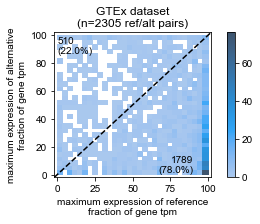

In [283]:
fig = plt.figure(figsize=(3.5, 3))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_ratio_gtex_ref", y="max_ratio_gtex_alt",
                  bins=30, cbar=True)
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xlabel("maximum expression of reference\nfraction of gene tpm")
ax.set_ylabel("maximum expression of alternative\nfraction of gene tpm")
ax.set_title("GTEx dataset\n(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_ratio_gtex_ref"] > ref_alt_map_nonan["max_ratio_gtex_alt"]])
ax.text(90, 0, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="right", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_ratio_gtex_ref"] < ref_alt_map_nonan["max_ratio_gtex_alt"]])
ax.text(0, 99, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="left", va="top")

ax.plot([-2,102], [-2, 102], color="black", linestyle="dashed")

fig.savefig('../figures/expression-ratio-scatter-ref_v_alt-gtex.pdf',
            bbox_inches='tight')

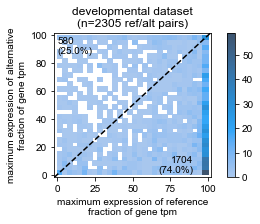

In [284]:
fig = plt.figure(figsize=(3.5, 3))

ax = sns.histplot(data=ref_alt_map_nonan, x="max_ratio_dev_ref", y="max_ratio_dev_alt",
                  bins=30, cbar=True)
ax.set_xlim((-2, 102))
ax.set_ylim((-2, 102))
ax.set_xlabel("maximum expression of reference\nfraction of gene tpm")
ax.set_ylabel("maximum expression of alternative\nfraction of gene tpm")
ax.set_title("developmental dataset\n(n=%s ref/alt pairs)" % len(ref_alt_map_nonan))

# find num where ref > alt
ra = len(ref_alt_map_nonan[ref_alt_map_nonan["max_ratio_dev_ref"] > ref_alt_map_nonan["max_ratio_dev_alt"]])
ax.text(90, 0, "%s\n(%s%%)" % (ra, round(ra/len(ref_alt_map_nonan), 2)*100), ha="right", va="bottom")

# find num where alt > ref
ar = len(ref_alt_map_nonan[ref_alt_map_nonan["max_ratio_dev_ref"] < ref_alt_map_nonan["max_ratio_dev_alt"]])
ax.text(0, 99, "%s\n(%s%%)" % (ar, round(ar/len(ref_alt_map_nonan), 2)*100), ha="left", va="top")

ax.plot([-2,102], [-2, 102], color="black", linestyle="dashed")

fig.savefig('../figures/expression-ratio-scatter-ref_v_alt-dev.pdf',
            bbox_inches='tight')

In [285]:
ref_alt_map_nonan["mm_dev_alt_delta"] = ref_alt_map_nonan["max_ratio_dev_alt"] - ref_alt_map_nonan["min_ratio_dev_alt"]
ref_alt_map_nonan["mm_dev_ref_delta"] = ref_alt_map_nonan["max_ratio_dev_ref"] - ref_alt_map_nonan["min_ratio_dev_ref"]
ref_alt_map_nonan["mm_gtex_alt_delta"] = ref_alt_map_nonan["max_ratio_gtex_alt"] - ref_alt_map_nonan["min_ratio_gtex_alt"]
ref_alt_map_nonan["mm_gtex_ref_delta"] = ref_alt_map_nonan["max_ratio_gtex_ref"] - ref_alt_map_nonan["min_ratio_gtex_ref"]
ref_alt_map_nonan.sample(5)

,ref,gene,alt,UID_rep_ref,max_gtex_ref,UID_rep_alt,max_gtex_alt,UID_rep_ref,max_dev_ref,UID_rep_alt,...,UID_rep_ref,max_ratio_dev_ref,min_ratio_dev_ref,UID_rep_alt,max_ratio_dev_alt,min_ratio_dev_alt,mm_dev_alt_delta,mm_dev_ref_delta,mm_gtex_alt_delta,mm_gtex_ref_delta
1482,NFATC4-201,NFATC4,NFATC4-204,NFATC4-201,4.043045,NFATC4-204,0.368561,NFATC4-201,1.843035,NFATC4-204,...,NFATC4-201,17.507048,0.000000,NFATC4-204,13.398982,0.000000,13.398982,17.507048,2.870870,32.137470
2128,ATF2-201|ATF2-203,ATF2,ATF2-202|ATF2-206,ATF2-201|ATF2-203,3.578304,ATF2-202|ATF2-206,3.668239,ATF2-201|ATF2-203,8.195171,ATF2-202|ATF2-206,...,ATF2-201|ATF2-203,90.360811,0.000000,ATF2-202|ATF2-206,63.014543,0.049383,62.965160,90.360811,48.105230,79.313792
1085,HNF4A-201,HNF4A,HNF4A-205,HNF4A-201,1.300183,HNF4A-205,1.970026,HNF4A-201,1.829432,HNF4A-205,...,HNF4A-201,75.455699,1.340941,HNF4A-205,16.079148,0.000000,16.079148,74.114757,11.350237,73.711366
472,ZSCAN31-201|ZSCAN31-202|ZSCAN31-203|ZSCAN31-209,ZSCAN31,ZSCAN31-214|ZSCAN31-219,ZSCAN31-201|ZSCAN31-202|ZSCAN31-203|ZSCAN31-209,5.797346,ZSCAN31-214|ZSCAN31-219,1.880425,ZSCAN31-201|ZSCAN31-202|ZSCAN31-203|ZSCAN31-209,7.249669,ZSCAN31-214|ZSCAN31-219,...,ZSCAN31-201|ZSCAN31-202|ZSCAN31-203|ZSCAN31-209,100.000000,20.124554,ZSCAN31-214|ZSCAN31-219,79.875446,0.000000,79.875446,79.875446,72.124824,72.124824
1525,ZNF169-202,ZNF169,ZNF169-203,ZNF169-202,0.906240,ZNF169-203,2.214159,ZNF169-202,2.416848,ZNF169-203,...,ZNF169-202,44.547343,0.000000,ZNF169-203,80.224861,16.678378,63.546483,44.547343,56.982592,25.875285


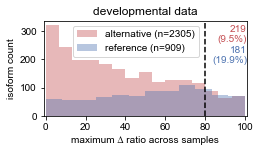

In [345]:
fig = plt.figure(figsize=(3.5, 2))

dd_ref = ref_alt_map_nonan[["ref", "mm_dev_ref_delta"]].drop_duplicates()
dd_alt = ref_alt_map_nonan[["alt", "mm_dev_alt_delta"]].drop_duplicates()

ax = sns.distplot(dd_alt["mm_dev_alt_delta"], color=sns.color_palette("deep")[3], kde=False,
                  label="alternative (n=%s)" % len(dd_alt))
sns.distplot(dd_ref["mm_dev_ref_delta"], color=sns.color_palette("deep")[0],
             kde=False, label="reference (n=%s)" % len(dd_ref), ax=ax)

ax.set_xlabel("maximum ∆ ratio across samples")
ax.set_ylabel("isoform count")
ax.set_title("developmental data")
ax.set_xlim((-1, 101))

ax.axvline(x=80, linestyle="dashed", color="black")

ref_o80 = len(dd_ref[dd_ref["mm_dev_ref_delta"] > 80])
alt_o80 = len(dd_alt[dd_alt["mm_dev_alt_delta"] > 80])

ax.text(101, 323, "%s\n(%s%%)" % (alt_o80, round(alt_o80/len(dd_alt)*100, 2)), ha="right", va="top", 
        color=sns.color_palette("deep")[3])
ax.text(101, 250, "%s\n(%s%%)" % (ref_o80, round(ref_o80/len(dd_ref)*100, 1)), ha="right", va="top", 
        color=sns.color_palette("deep")[0])

plt.legend(loc=2, bbox_to_anchor=(0.12, 1))
fig.savefig('../figures/expression-histogram-max_delta-dev.pdf',
            bbox_inches='tight')

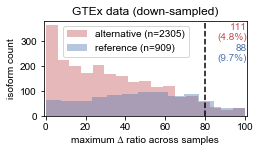

In [346]:
fig = plt.figure(figsize=(3.5, 2))

dd_ref = ref_alt_map_nonan[["ref", "mm_gtex_ref_delta"]].drop_duplicates()
dd_alt = ref_alt_map_nonan[["alt", "mm_gtex_alt_delta"]].drop_duplicates()

ax = sns.distplot(dd_alt["mm_gtex_alt_delta"], color=sns.color_palette("deep")[3], kde=False,
                  label="alternative (n=%s)" % len(dd_alt))
sns.distplot(dd_ref["mm_gtex_ref_delta"], color=sns.color_palette("deep")[0],
             kde=False, label="reference (n=%s)" % len(dd_ref), ax=ax)

ax.set_xlabel("maximum ∆ ratio across samples")
ax.set_ylabel("isoform count")
ax.set_title("GTEx data (down-sampled)")
ax.set_xlim((-1, 101))

ax.axvline(x=80, linestyle="dashed", color="black")

ref_o80 = len(dd_ref[dd_ref["mm_gtex_ref_delta"] > 80])
alt_o80 = len(dd_alt[dd_alt["mm_gtex_alt_delta"] > 80])

ax.text(101, 375, "%s\n(%s%%)" % (alt_o80, round(alt_o80/len(dd_alt)*100, 1)), ha="right", va="top", 
        color=sns.color_palette("deep")[3])
ax.text(101, 290, "%s\n(%s%%)" % (ref_o80, round(ref_o80/len(dd_ref)*100, 1)), ha="right", va="top", 
        color=sns.color_palette("deep")[0])

plt.legend(loc=2, bbox_to_anchor=(0.07, 1))
fig.savefig('../figures/expression-histogram-max_delta-gtex.pdf',
            bbox_inches='tight')

### # make domain figure - move this into domain notebook at some point

In [323]:
# loop through ref/alt pairs above and calculate total num AAs inserted/deleted/frameshifted
tot_ins = []
tot_perc_ins = []
tot_dd = []
tot_perc_dd = []
tot_f = []
tot_perc_f = []

tot_ins_dom = []
tot_perc_ins_dom = []
tot_dd_dom = []
tot_perc_dd_dom = []
tot_f_dom = []
tot_perc_f_dom = []

for i, row in ref_alt_map_nonan.iterrows():
    ref = row.ref.split("|")[0]
    alt = row.alt.split("|")[0]
    gene = ref[:-4]
    
    # manual fixes
    if gene == "AC092072.1":
        gene = "ZNF223"
    if gene == "AC008554.1":
        gene = "ZNF737"
    if gene == "AC073611.1":
        gene = "SP7"
    if gene == "AC118549.1":
        gene = "ZZZ3"
    if gene == "ZUP1":
        gene = "ZUFSP"
    if gene == "AC139768.1":
        gene = "POU6F1"
    if gene == "PHF19":
        gene = "PHF19 "
    #print("gene: %s | ref: %s | alt: %s" % (gene, ref, alt))
    
    pp_str = tfs[gene].pairwise_changes_relative_to_reference(ref, alt)
    aa_ftr = tfs[gene].aa_feature_disruption(ref)
    if len(aa_ftr) == 0:
        ins_dom = 0
        perc_ins_dom = 0
        dd_dom = 0
        perc_dd_dom = 0
        f_dom = 0
        perc_f_dom = 0
    else:
        aa_ftr_alt = aa_ftr[aa_ftr["alt_iso"] == alt]
        aa_ftr_alt_dom_grp = aa_ftr_alt.groupby("alt_iso")[["deletion",
                                                            "insertion",
                                                            "frameshift"]].agg("sum").reset_index()
        
        ins_dom = aa_ftr_alt_dom_grp.insertion.iloc[0]
        perc_ins_dom = ins_dom/len(pp_str)*100
        dd_dom = aa_ftr_alt_dom_grp.deletion.iloc[0]
        perc_dd_dom = dd_dom/len(pp_str)*100
        f_dom = aa_ftr_alt_dom_grp.frameshift.iloc[0]
        perc_f_dom = f_dom/len(pp_str)*100
    
    
    ins = pp_str.count("I")
    perc_ins = ins/len(pp_str)*100
    dd = pp_str.count("D")
    perc_dd = dd/len(pp_str)*100
    f = pp_str.count("F")
    f += pp_str.count("f")
    perc_f = f/len(pp_str)*100
    
#     print("# insertions: %s (%s%%) | # deletions: %s (%s%%) | # frameshifts: %s (%s%%)" % (ins, perc_ins,
#                                                                                            dd, perc_dd,
#                                                                                            f, perc_f))
    
    tot_ins.append(ins)
    tot_perc_ins.append(perc_ins)
    tot_dd.append(dd)
    tot_perc_dd.append(perc_dd)
    tot_f.append(f)
    tot_perc_f.append(perc_f)
    
    tot_ins_dom.append(ins_dom)
    tot_perc_ins_dom.append(perc_ins_dom)
    tot_dd_dom.append(dd_dom)
    tot_perc_dd_dom.append(perc_dd_dom)
    tot_f_dom.append(f_dom)
    tot_perc_f_dom.append(perc_f_dom)

ref_alt_map_nonan["n_ins"] = tot_ins
ref_alt_map_nonan["perc_ins"] = tot_perc_ins
ref_alt_map_nonan["n_dd"] = tot_dd
ref_alt_map_nonan["perc_dd"] = tot_perc_dd
ref_alt_map_nonan["n_f"] = tot_f
ref_alt_map_nonan["perc_f"] = tot_perc_f

ref_alt_map_nonan["n_ins_dom"] = tot_ins_dom
ref_alt_map_nonan["perc_ins_dom"] = tot_perc_ins_dom
ref_alt_map_nonan["n_dd_dom"] = tot_dd_dom
ref_alt_map_nonan["perc_dd_dom"] = tot_perc_dd_dom
ref_alt_map_nonan["n_f_dom"] = tot_f_dom
ref_alt_map_nonan["perc_f_dom"] = tot_perc_f_dom
ref_alt_map_nonan.sample(5)

,ref,gene,alt,UID_rep_ref,max_gtex_ref,UID_rep_alt,max_gtex_alt,UID_rep_ref,max_dev_ref,UID_rep_alt,...,n_dd,perc_dd,n_f,perc_f,n_ins_dom,perc_ins_dom,n_dd_dom,perc_dd_dom,n_f_dom,perc_f_dom
391,ZNF551-201,ZNF551,ZNF551-202,ZNF551-201,3.105826,ZNF551-202,1.716178,ZNF551-201,4.630446,ZNF551-202,...,618,91.420118,0,0.0,0,0.0,453,67.011834,0,0.0
547,CSRNP3-201|CSRNP3-202|CSRNP3-207,CSRNP3,CSRNP3-203,CSRNP3-201|CSRNP3-202|CSRNP3-207,4.016010,CSRNP3-203,0.315033,CSRNP3-201|CSRNP3-202|CSRNP3-207,11.000000,CSRNP3-203,...,0,0.000000,0,0.0,0,0.0,0,0.000000,0,0.0
1818,ZNF655-201|ZNF655-204,ZNF655,ZNF655-212|ZNF655-222,ZNF655-201|ZNF655-204,4.384106,ZNF655-212|ZNF655-222,2.400500,ZNF655-201|ZNF655-204,6.188264,ZNF655-212|ZNF655-222,...,0,0.000000,0,0.0,0,0.0,0,0.000000,0,0.0
1262,ZNF565-201|ZNF565-203,ZNF565,ZNF565-202,ZNF565-201|ZNF565-203,3.516522,ZNF565-202,1.606771,ZNF565-201|ZNF565-203,5.056407,ZNF565-202,...,0,0.000000,0,0.0,0,0.0,0,0.000000,0,0.0
72,HMBOX1-201|HMBOX1-203,HMBOX1,HMBOX1-202|HMBOX1-206,HMBOX1-201|HMBOX1-203,3.676121,HMBOX1-202|HMBOX1-206,0.623669,HMBOX1-201|HMBOX1-203,6.677481,HMBOX1-202|HMBOX1-206,...,46,10.648148,0,0.0,0,0.0,1,0.231481,0,0.0


In [324]:
def mimic_r_boxplot(ax):
    for i, patch in enumerate(ax.artists):
        r, g, b, a = patch.get_facecolor()
        col = (r, g, b, 1)
        patch.set_facecolor((r, g, b, .5))
        patch.set_edgecolor((r, g, b, 1))

        # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same colour as above
        line_order = ["lower", "upper", "whisker_1", "whisker_2", "med", "fliers"]
        for j in range(i*6,i*6+6):
            elem = line_order[j%6]
            line = ax.lines[j]
            if "whisker" in elem:
                line.set_visible(False)
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)
            if "fliers" in elem:
                line.set_alpha(0.5)

In [327]:
to_plot = pd.melt(ref_alt_map_nonan, id_vars=["ref", "gene", "alt"], value_vars=["n_ins", "perc_ins",
                                                                                 "n_dd", "perc_dd",
                                                                                 "n_f", "perc_f",
                                                                                 "n_ins_dom", "perc_ins_dom",
                                                                                 "n_dd_dom", "perc_dd_dom",
                                                                                 "n_f_dom", "perc_f_dom"])
to_plot["dom_cat"] = to_plot["variable"].str.contains("dom")
to_plot["n_or_perc"] = to_plot["variable"].str.split("_", expand=True)[0]
to_plot["type"] = to_plot["variable"].str.split("_", expand=True)[1]
to_plot.sample(5)

,ref,gene,alt,variable,value,dom_cat,n_or_perc,type
9199,MYT1L-204|MYT1L-218|MYT1L-220,MYT1L,MYT1L-245,perc_dd,27.487352,False,perc,dd
3620,ZSCAN21-201,ZSCAN21,ZSCAN21-203,perc_ins,2.272727,False,perc,ins
9644,HIVEP3-201,HIVEP3,HIVEP3-202|HIVEP3-207,n_f,0.000000,False,n,f
4098,TCF4-201|TCF4-267,TCF4,TCF4-210,perc_ins,3.314121,False,perc,ins
13190,MAX-205,MAX,MAX-203,perc_f,0.000000,False,perc,f


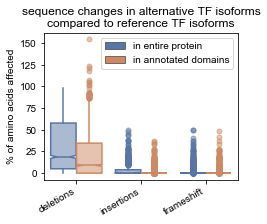

In [353]:
fig = plt.figure(figsize=(3.6, 3))
ax = sns.boxplot(data=to_plot[to_plot["n_or_perc"] == "perc"], 
                 x="type", y="value", hue="dom_cat", order=["dd", "ins", "f"],
                 palette=sns.color_palette("deep"), fliersize=5, notch=True,
                 flierprops={"marker": "o"})
mimic_r_boxplot(ax)
ax.set_xlabel("")
ax.set_xticklabels(["deletions", "insertions", "frameshift"], rotation=30, ha="right", va="top")
ax.set_ylabel("% of amino acids affected")
ax.set_title("sequence changes in alternative TF isoforms\ncompared to reference TF isoforms")
handles, labels = ax.get_legend_handles_labels()
labels = ["in entire protein", "in annotated domains"]
ax.legend(handles, labels)
fig.savefig('../figures/domain-overall-boxplot.pdf',
            bbox_inches='tight')

In [355]:
to_plot[to_plot["n_or_perc"] == "perc"].groupby(["type", "dom_cat"]).agg("median")

value
type dom_cat           
dd   False    18.681319
     True      9.019608
f    False     0.000000
     True      0.000000
ins  False     0.503356
     True      0.000000

In [365]:
len(ref_alt_map_nonan[ref_alt_map_nonan["perc_f_dom"] > 0])

214

In [357]:
len(ref_alt_map_nonan[ref_alt_map_nonan["perc_f"] >= 10])

68

In [358]:
len(ref_alt_map_nonan)

2305

In [366]:
214/2305

0.0928416485900217